# Smooth bathymetry  -grab from Susan's notebook

In [1]:
from __future__ import division, print_function
from salishsea_tools import (nc_tools,viz_tools,tidetools)
from salishsea_tools.nowcast import figures
import scipy.io as sio
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
%matplotlib inline

In [2]:
bathy_3 = nc.Dataset('bathy_meter_SalishSea3.nc','r+' )
bathyy_3 = bathy_3.variables['Bathymetry'][:]
bathyy_3[418,395]

13.125

In [3]:
def find_max(bathy):
    i,j = np.unravel_index(bathy.argmax(), bathy.shape)
    return i,j

In [4]:
def find_slope(bathy,di,dj):
    imax, jmax = bathy.shape
    Da = 0.5*(bathy[di:,dj:]+bathy[0:imax-di,0:jmax-dj])
    Dd = bathy[di:,dj:]-bathy[0:imax-di,0:jmax-dj]
    return Dd/Da

In [5]:
def smooth(gamma,bathy,i,j,di,dj):
    a = 0.5*(bathy[i,j]+bathy[i+di,j+dj])
    if bathy[i,j] < bathy[i+di,j+dj]:
        change = gamma
    else:
        change = -gamma
    bathy[i,j] = bathy[i,j] + gamma*a
    bathy[i+di,j+dj] = bathy[i+di,j+dj] - gamma*a

In [6]:
gamma = 0.2
maxslope = 0.8

slopei = find_slope(bathyy_3,1,0)
i,j = find_max(slopei)
slopej = find_slope(bathyy_3,0,1)
k,l = find_max(slopej)
while np.maximum(slopei[i,j],slopej[k,l]) > maxslope:
    if slopei[i,j] > slopej[k,l]:
        smooth(gamma,bathyy_3,i,j,1,0)
    else:
        smooth(gamma,bathyy_3,k,l,0,1)
    slopei = find_slope(bathyy_3,1,0)
    i,j = find_max(slopei)
    slopej = find_slope(bathyy_3,0,1)
    k,l = find_max(slopej)

print (slopei[i,j])
print (slopej[i,j])

0.8
--


In [7]:
bathy_3.close()

# Create new t,s file for new bathymetry

In [1]:
from __future__ import division
from salishsea_tools import nc_tools
from salishsea_tools import tidetools
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
%matplotlib inline

In [2]:
#old bathymetry inforamtion
old_path = '../nemo-forcing/grid/bathy_meter_SalishSea2.nc'
old_bathy = nc.Dataset(old_path, 'r')
old_depth = old_bathy.variables['Bathymetry']

In [3]:
#old initial file
initial_path = '/data/dlatorne/MEOPAR/SalishSea/nowcast/14jun15/SalishSea_02401920_restart.nc'
T_S = nc.Dataset(initial_path, 'r')

In [4]:
#nc_tools.show_variables(T_S)
old_T = T_S.variables['tb'][0] # omit the first dimension
old_S = T_S.variables['sb'][0]
depths = T_S.variables['nav_lev']
lon = T_S.variables['nav_lon']
lat = T_S.variables['nav_lat']
print (old_T[:, 427, 292])
print(depths[0:40])

[ 14.77021985  14.34337293  14.20415199  13.84946759  13.67585241
  13.59131301  13.64740562  13.5873905   13.43705051  13.34423781
  13.15459748  13.03363     12.96472808  12.91797194  12.89496075
  12.87349044  12.84061662  12.78115335  12.70208798  12.59582154
  12.51719442  12.35120913  12.09723483   0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.        ]
[   0.5000003     1.5000031     2.50001144    3.50003052    4.50007057
    5.50015068    6.50031042    7.50062323    8.50123596    9.50243282
   10.50476551   11.50931168   12.51816654   13.53541183   14.56898212
   15.63428783   16.76117325   18.00713539   19.48178482   21.38997841
   24.10025597   28.22991562   34.68575668   44.51772308   58.48433304
   76.58558655   98.06295776  121.86651611  147.08946228  173.11448669
  199.57304382  226.26029968  253.06663513  279.93453979  306.

(898, 398)


<matplotlib.colorbar.Colorbar instance at 0x7fb826829b00>

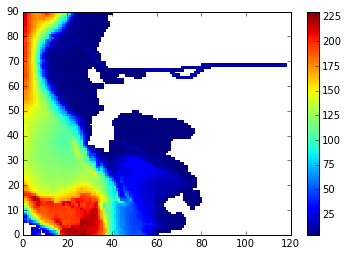

In [5]:
#read in new bathymetry
new_path = '/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea3.nc'
Fraser = nc.Dataset(new_path, 'r')
bathy = Fraser.variables['Bathymetry'][:]
print(bathy.shape)
plt.pcolormesh(bathy[350: 440, 280 : 398])
plt.colorbar()

In [6]:
floor = np.empty_like(depths)
ceil = np.empty_like(depths)
ceil[0] = 0.
floor[0] = 2*depths[0]
for k in range(1,40):
    ceil[k] = floor[k-1]
    floor[k] = 2*depths[k] -floor[k-1]

In [7]:
S = np.empty_like(old_S)
T = np.empty_like(old_T)
#for every cell with top of cell depth < bathymetry, use old TS, if old TS=0, find closest point and use that.
for k in range(40):
    for j in range(398):
        for i in range(898):
            if ceil[k] < bathy[i,j]:
                if old_S[k,i,j] <> 0:
                    S[k,i,j] = old_S[k, i, j]
                    T[k,i,j] = old_T[k, i, j]
                else:
                    # closest neighbour thing
                    masked_array = np.ma.array(old_S[k], mask = old_S[k] == 0)
                    X, Y = tidetools.find_closest_model_point(lon[i,j], lat[i,j], lon, lat, masked_array)
                    S[k, i, j] = old_S[k, X, Y]
                    T[k, i, j] = old_T[k, X, Y]

In [8]:
# build nc file
new_TS = nc.Dataset('TSforextendedFraserRiver.nc', 'w')
nc_tools.init_dataset_attrs(
    new_TS, 
    title='Salinity Temperature Initial Conditions based on Nowcast June 14, 2015 for extended Fraser river channel', 
    notebook_name='Smooth bathymetry & Create New TS file', 
    nc_filepath='/ocean/jieliu/research/meopar/nemo-forcing/initial_strat/TSforextendedFraserRiver.nc',
    comment='Salinity and Temperature conditions from nowcast June 14, 2015 onto extended Fraser bathymetry')
new_TS.createDimension('y', 898)
new_TS.createDimension('x', 398)
new_TS.createDimension('deptht',size = len(depths))
new_TS.createDimension('time_counter', None)
nc_tools.show_dimensions(new_TS)
# show variables
nav_lat = new_TS.createVariable('nav_lat', 'float32', ('y','x'))
nav_lat.long_name = 'Latitude'
nav_lat.units = 'degrees_north'
nav_lat = lat
nav_lon = new_TS.createVariable('nav_lon', 'float32', ('y','x'))
nav_lon.long_name = 'Longitude'
nav_lon.units = 'degrees_east'
nav_lon = lon
deptht = new_TS.createVariable('deptht', 'float32', ('deptht'))
deptht.long_name = 'Depth'
deptht.units = 'm'
deptht.positive = 'down'
deptht.valid_range = np.array((4., 428.))##minimum depth 4m
deptht = depths
time_counter = new_TS.createVariable('time_counter', 'float32', ('time_counter'))
time_counter.units = 'seconds since 2015-06-14 0:00:00'
time_counter.long_name = 'Time axis'
vosaline = new_TS.createVariable('vosaline', 'float32', 
                               ('time_counter','deptht','y','x'))
vosaline.units = 'none'
vosaline.long_name = 'Practical Salinity'  
vosaline.coordinates = 'nav_lon nav_lat deptht time_counter'
vosaline.grid = 'SalishSea3, extended Fraser'
vosaline[0] = S
votemper = new_TS.createVariable('votemper', 'float32', 
                               ('time_counter','deptht','y','x'))
votemper.units = 'degC'
votemper.long_name = 'Temperature' 
votemper.coordinates = 'nav_lon nav_lat deptht time_counter'
votemper[0] = T
new_TS.history = """[2015-06-14] Created"""

file format: NETCDF4
Conventions: CF-1.6
title: Salinity Temperature Initial Conditions based on Nowcast June 14, 2015 for extended Fraser river channel
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: REQUIRED
references: REQUIRED
history: [2015-06-27 16:03:00] Created netCDF4 zlib=True dataset.
comment: Salinity and Temperature conditions from nowcast June 14, 2015 onto extended Fraser bathymetry
<type 'netCDF4.Dimension'>: name = 'y', size = 898

<type 'netCDF4.Dimension'>: name = 'x', size = 398

<type 'netCDF4.Dimension'>: name = 'deptht', size = 40

<type 'netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 0



<matplotlib.colorbar.Colorbar instance at 0x7fb826550a28>

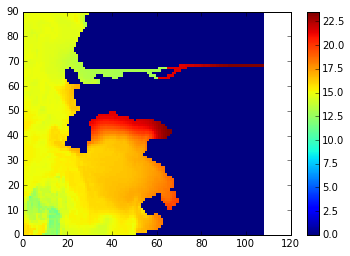

In [9]:
## temperature before
plt.pcolormesh(votemper[0,0, 350: 440, 290 : 398])
plt.colorbar()

In [10]:
## modify temperature for some grid cells
k = 0 
i = 413
j = 351
votemper[0, k : k + 4, i, j : j + 5] = 14. ## for(413, 351:355) from 0 to 4m
votemper[0, k : k + 4, i + 4, j + 4: j +13] = 14. ## for (417, 355:363).. ..
votemper[0, k : k + 4, i + 1, j + 4: j + 7] = 14. ## for (414, 355:357).. ..
votemper[0, k : k + 4, i + 2, j + 6: j + 8] = 14. ## for (415, 357:358).. ..
votemper[0, k : k + 4, i + 3, j + 7: j + 10] = 14. ## for (416, 358:360).. ..
votemper[0, k : k + 4, i + 5, j + 9: j + 47] = 14. ## for (418, 360:397).. ..

<matplotlib.colorbar.Colorbar instance at 0x7fb82643aa70>

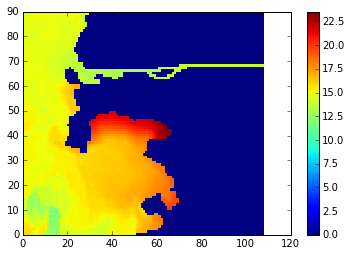

In [11]:
## temperature after
plt.pcolormesh(votemper[0,0, 350: 440, 290 : 398])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7fb8262ad170>

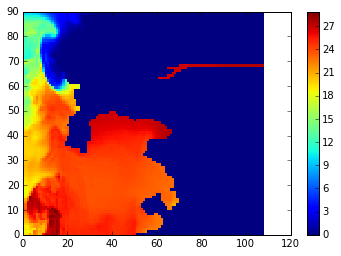

In [12]:
## salinity before
plt.pcolormesh(vosaline[0,0, 350: 440, 290 : 398])
plt.colorbar()

In [13]:
## set salinity after New Westminster as 1,before as 4,river source cell as 0
k = 0 
i = 418
j = 365
vosaline[0, k : k + 4, i-2, j-30: j-13] = 4.#16,335:351)(416 ,358:360)from 0 to 4m
vosaline[0, k : k + 4, i -2, j -7: j -4] = 4.
vosaline[0, k : k + 4, i -1,j -14:j -1] = 4.#(417, 351:363)..  ..
vosaline[0, k : k + 4, i - 4, j - 18: j - 15] = 4.## for (414, 347:349)( 414, 355:357).. ..
vosaline[0, k : k + 4, i - 4, j - 10: j - 7] = 4.
vosaline[0, k : k + 4, i - 5,j - 16:j- 9]=4.## for (413, 349:355)
vosaline[0, k : k + 4, i - 3, j  - 19:j-17] = 4.#(415, 346, 347, 357, 358).. ..
vosaline[0, k : k + 4, i - 3, j  - 8: j - 6] = 4.
vosaline[0, k : k + 4, i , j -5 : j +1] = 4.#for(418,360:365) .. ..
vosaline[0, k : k + 4, i , j +1: j + 32]=1.# (418, 366:397)  .. after New Westminster
vosaline[0, k : , i , j + 32] = 0 

In [17]:
## make original salinity of freshwater source point as 4
vosaline[0, 0:4 , 416, 334] = 4.

In [14]:
## modify damp salinity values
k = 0; i = 425; j = 302; d = 4.
vosaline[0, k: k +4, i, j+1] = d
vosaline[0, k: k +4, i-1, j:j+3] = d
vosaline[0, k: k +4, i-2, j+1:j+5] = d
vosaline[0, k: k +4, i-3, j+3:j+7] = d
vosaline[0, k: k +4, i-4, j+5:j+9] = d
vosaline[0, k: k +4, i-5, j+7:j+11] = d
vosaline[0, k: k +4, i-6, j+9:j+13] = d
vosaline[0, k: k +4, i-7, j+11:j+14] = d
vosaline[0, k: k +4, i-8, j+12:j+16] = d

In [15]:
## modify salinity values of straight channel connect damp and further extended channel
k = 0; i = 416; j = 317; d= 4.
vosaline[0, k : k +4, i, j-1:j+18] = d

<matplotlib.colorbar.Colorbar instance at 0x7fb8257508c0>

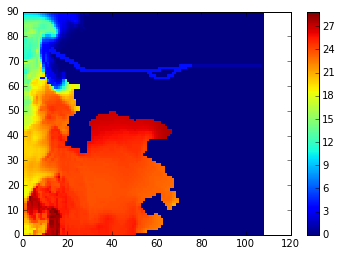

In [44]:
## salinity after
plt.pcolormesh(vosaline[0,0, 350: 440, 290 : 398])
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7fb82550d1b8>

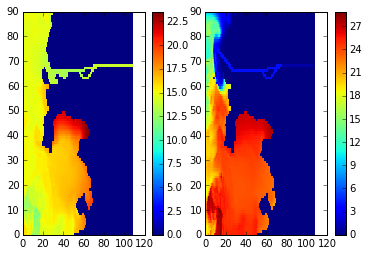

In [45]:
plt.subplot(1, 2, 1)
plt.pcolormesh(votemper[0,0, 350: 440, 290 : 398])
plt.colorbar()
plt.subplot(1, 2, 2)
plt.pcolormesh(vosaline[0,0, 350: 440, 290 : 398])
plt.colorbar()

In [46]:
new_TS.close()